In [1]:
!pip install --upgrade scipy

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import os, pathlib, glob, random
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.metrics import confusion_matrix
import scipy
from scipy import io

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
batch_size = 32
output_nodes = 10
learning_rate = 0.001

In [5]:
train_data_path = r"/kaggle/input/mgdcc-feature/MGDCC/train"
val_data_path = r"/kaggle/input/mgdcc-feature/MGDCC/dev"
test_data_path = r"/kaggle/input/mgdcc-feature/MGDCC/test"

In [6]:
import os
import random
import numpy as np
import scipy.io
from torch.utils.data import Dataset
import torch

class PtDataset(Dataset):
    def __init__(self, directory, max_len=10):
        """
        Custom dataset for loading .mat files from a directory structure.
        Args:
            directory (str): The path to the root data directory.
            max_len (int): The maximum sequence length for padding/truncating.
        """
        self.directory = directory
        self.classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.files = []
        self.max_len = max_len
        for c in self.classes:
            c_dir = os.path.join(directory, c)
            c_files = [(os.path.join(c_dir, f), self.class_to_idx[c]) for f in os.listdir(c_dir) if f.endswith('.mat')]
            self.files.extend(c_files)
        random.shuffle(self.files)
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        """
        Load a .mat file, process it to the required shape, and return it with the label.
        """
        filepath, label = self.files[idx]
        try:
            mat_vals = scipy.io.loadmat(filepath)
            data = mat_vals['final']  # Assuming 'final' is the key for data
            data = data.T  # Transpose to (time, features)
            feature_dim = data.shape[1]

            # Ensure data is exactly (max_len, feature_dim)
            if data.shape[0] < self.max_len:
                pad_width = self.max_len - data.shape[0]
                data = np.pad(data, pad_width=((0, pad_width), (0, 0)), mode='constant')
            else:
                data = data[:self.max_len, :]

            # Flatten data to fit conv1d input (batch_size, in_channels, length)
            data = data.reshape(1, -1)  # Reshape to (1, max_len * feature_dim)
            data = torch.from_numpy(data).double()  # Convert to tensor
        except Exception as e:
            print(f"Error loading file {filepath}: {str(e)}")
            return self.__getitem__((idx + 1) % len(self.files))  # Retry with a different sample

        return data, label


In [7]:

train_dataset = PtDataset(train_data_path)
val_dataset = PtDataset(val_data_path)
test_dataset = PtDataset(test_data_path)

In [8]:
class PtDataLoader(DataLoader):
    def __init__(self, directory, batch_size, shuffle=True):
        dataset = PtDataset(directory)
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle)

In [9]:
train_dataloader = PtDataLoader(directory=train_data_path, batch_size=batch_size)
val_dataloader = PtDataLoader(directory=val_data_path, batch_size=batch_size)
test_dataloader = PtDataLoader(directory=test_data_path, batch_size=batch_size)

In [10]:
train_count = len(train_dataset) 
val_count = len(val_dataset)
test_count = len(test_dataset)

In [11]:
print(train_count)
print(val_count)
print(test_count)

111633
37152
37971


In [12]:
drop_amount = 0.255

import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from torch.nn.parameter import Parameter
from torch.utils import data

class Res2NetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale=4, kernel_size=3, stride=1, padding=1):
        super(Res2NetBlock, self).__init__()
        assert out_channels % scale == 0, "Output channels must be divisible by scale"
        self.scale = scale
        self.split_channels = out_channels // scale

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)

        self.convs = nn.ModuleList([
            nn.Conv1d(self.split_channels, self.split_channels, kernel_size, stride=stride, padding=padding, bias=False)
            for _ in range(scale - 1)
        ])

        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1, bias=False)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        splits = torch.chunk(out, self.scale, dim=1)
        out = splits[0]
        result = [out]  # Collect outputs here to avoid in-place addition
        for i, conv in enumerate(self.convs):
            result.append(conv(splits[i + 1]))
        out = torch.cat(result, dim=1)  # Concatenate all parts

        out = self.conv3(out)
        out = self.bn2(out)
        return self.relu(out)


class AMSoftmaxLoss(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.4):
        super(AMSoftmaxLoss, self).__init__()
        self.s = s
        self.m = m
        self.weight = Parameter(torch.DoubleTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x, labels):
        cosine = F.linear(F.normalize(x), F.normalize(self.weight))
        phi = cosine - self.m
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)
        logits = one_hot * phi + (1.0 - one_hot) * cosine
        logits *= self.s
        return logits


class AASIST2(nn.Module):
    def __init__(self, d_args):
        super(AASIST2, self).__init__()
        self.res2net_block1 = Res2NetBlock(d_args['in_channels'], d_args['filts'][0], scale=4)
        self.res2net_block2 = Res2NetBlock(d_args['filts'][0], d_args['filts'][1], scale=4)
        self.res2net_block3 = Res2NetBlock(d_args['filts'][1], d_args['filts'][2], scale=4)

        self.gru = nn.GRU(input_size=d_args['filts'][2],
                          hidden_size=d_args['gru_node'],
                          num_layers=d_args['nb_gru_layer'],
                          batch_first=True)

        self.fc1 = nn.Linear(d_args['gru_node'], d_args['nb_fc_node'])  # Input size must match GRU hidden size
        self.fc2 = nn.Linear(d_args['nb_fc_node'], d_args['nb_classes'])  # Matches number of classes

        self.am_softmax = AMSoftmaxLoss(d_args['nb_fc_node'], d_args['nb_classes'])  # Use fc1 output size

    def forward(self, x, labels=None, is_test=False):
        x = self.res2net_block1(x)
        x = self.res2net_block2(x)
        x = self.res2net_block3(x)

        x = x.permute(0, 2, 1)  # Permute for GRU input [batch, sequence, feature]
        self.gru.flatten_parameters()
        x, _ = self.gru(x)
        x = x[:, -1, :]  # Take last time step output

        x = self.fc1(x)
        logits = self.fc2(x)

        if labels is not None:  # Compute AMSoftmax only if labels are provided
            return self.am_softmax(x, labels)
        else:  # Return logits for testing/inference
            return F.softmax(logits, dim=1)

d_args = {
    'in_channels': 1,
    'filts': [64, 128, 256],
    'gru_node': 128,
    'nb_gru_layer': 2,
    'nb_fc_node': 64,
    'nb_classes': 2
}
model = AASIST2(d_args)


In [13]:
import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F

In [14]:
# Define the parameters
# input_size = 20
# hidden_size = 256
# num_layers = 2
# num_classes = 8

# model = BiLSTMClassifier(input_size, hidden_size, num_layers, num_classes)
model.to(device, dtype=torch.double)

AASIST2(
  (res2net_block1): Res2NetBlock(
    (conv1): Conv1d(1, 64, kernel_size=(1,), stride=(1,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convs): ModuleList(
      (0-2): 3 x Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    )
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
    (relu): ReLU(inplace=True)
  )
  (res2net_block2): Res2NetBlock(
    (conv1): Conv1d(64, 128, kernel_size=(1,), stride=(1,), bias=False)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convs): ModuleList(
      (0-2): 3 x Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    )
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=Fal

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

In [16]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
print(model)

AASIST2(
  (res2net_block1): Res2NetBlock(
    (conv1): Conv1d(1, 64, kernel_size=(1,), stride=(1,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convs): ModuleList(
      (0-2): 3 x Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    )
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
    (relu): ReLU(inplace=True)
  )
  (res2net_block2): Res2NetBlock(
    (conv1): Conv1d(64, 128, kernel_size=(1,), stride=(1,), bias=False)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convs): ModuleList(
      (0-2): 3 x Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    )
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=Fal

In [18]:
#Model training and testing 
n_total_steps = len(train_dataloader) # n_total_steps * batch size will give total number of training files (consider that last batch may not be fully filled)
train_accuracy_list = []
train_loss_list = []
val_accuracy_list = []
max_acc=0
num_epochs = 40
pred_labels =[]
act_labels = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0
    
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy += int((prediction == labels).sum().item())
    
    train_accuracy /= train_count
    train_loss /= train_count
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    
    # Validation
    model.eval()
    val_accuracy = 0.0
    pred = []
    lab = []
    
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, prediction = torch.max(outputs.data, 1)
            val_accuracy += int((prediction == labels).sum().item())
            pred.extend(prediction.cpu().tolist())
            lab.extend(labels.cpu().tolist())
    
    val_accuracy /= val_count
    val_accuracy_list.append(val_accuracy)
    
    if max_acc < val_accuracy:
        max_acc = val_accuracy
        pred_labels = pred
        actual_labels = lab
        torch.save(model, "best_accuracy_model_BiLSTM.pth")
    
    print(f"Epoch: {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

print("Max Accuracy:", max_acc)


Epoch: 1/40, Train Loss: 0.6931, Train Accuracy: 0.5113, Val Accuracy: 0.5140
Epoch: 2/40, Train Loss: 0.6929, Train Accuracy: 0.5119, Val Accuracy: 0.5140
Epoch: 3/40, Train Loss: 0.6929, Train Accuracy: 0.5121, Val Accuracy: 0.5140
Epoch: 4/40, Train Loss: 0.6929, Train Accuracy: 0.5120, Val Accuracy: 0.5140
Epoch: 5/40, Train Loss: 0.6929, Train Accuracy: 0.5113, Val Accuracy: 0.5140
Epoch: 6/40, Train Loss: 0.6929, Train Accuracy: 0.5121, Val Accuracy: 0.5140
Epoch: 7/40, Train Loss: 0.6929, Train Accuracy: 0.5118, Val Accuracy: 0.5140
Epoch: 8/40, Train Loss: 0.6929, Train Accuracy: 0.5121, Val Accuracy: 0.5140
Epoch: 9/40, Train Loss: 0.6929, Train Accuracy: 0.5119, Val Accuracy: 0.5140
Epoch: 10/40, Train Loss: 0.6929, Train Accuracy: 0.5121, Val Accuracy: 0.5140
Epoch: 11/40, Train Loss: 0.6929, Train Accuracy: 0.5120, Val Accuracy: 0.5140
Epoch: 12/40, Train Loss: 0.6929, Train Accuracy: 0.5120, Val Accuracy: 0.5140
Epoch: 13/40, Train Loss: 0.6929, Train Accuracy: 0.5115, Val

In [19]:
import torch
from torch.autograd import Variable

# Load the best model
best_model = torch.load("best_accuracy_model_BiLSTM.pth")

# Put the best_model in evaluation mode
best_model.eval()

# Initialize variables to store results
testing_accuracy = 0.0
pred_labels = []
act_labels = []

# Iterate over the test dataloader
for i, (images, labels) in enumerate(test_dataloader):
    if torch.cuda.is_available():
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
    else:
        images = Variable(images)
        labels = Variable(labels)

    # Pass the images through the model for inference
    outputs = best_model(images, labels=None, is_test=True)
    
    # Get predictions by taking the index with the highest score
    _, prediction = torch.max(outputs.data, 1)
    
    # Calculate the number of correct predictions
    testing_accuracy += (prediction == labels).sum().item()
    
    # Store predicted and actual labels
    pred_labels.extend(prediction.cpu().tolist())
    act_labels.extend(labels.cpu().tolist())

# Calculate the testing accuracy
testing_accuracy /= len(test_dataloader.dataset)

# Print the testing accuracy
print(f"Testing Accuracy: {testing_accuracy * 100:.2f}%")


<ipython-input-19-4beedf5fee82>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load("best_accuracy_model_BiLSTM.pth")


Testing Accuracy: 90.22%


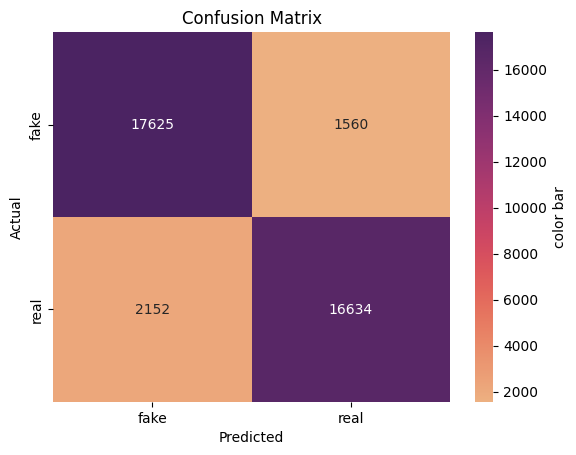

F1 Score :  0.9021745501829812


In [20]:
# Calculate the confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(act_labels, pred_labels)
# Plot confusion matrix heat map
sns.heatmap(conf_mat, cmap="flare",annot=True, fmt = "g", 
            cbar_kws={"label":"color bar"},
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("ConfusionMatrix_BiLSTM.png")
plt.show()
from sklearn.metrics import f1_score
f1_score = f1_score(pred_labels, act_labels, average='macro')
print('F1 Score : ', f1_score)

In [21]:
import numpy as np
import sklearn.metrics

"""
Python compute equal error rate (eer)
ONLY tested on binary classification

:param label: ground-truth label, should be a 1-d list or np.array, each element represents the ground-truth label of one sample
:param pred: model prediction, should be a 1-d list or np.array, each element represents the model prediction of one sample
:param positive_label: the class that is viewed as positive class when computing EER
:return: equal error rate (EER)
"""
def compute_eer(label, pred):
    # all fpr, tpr, fnr, fnr, threshold are lists (in the format of np.array)
    fpr, tpr, threshold = sklearn.metrics.roc_curve(label, pred)
    fnr = 1 - tpr

    # the threshold of fnr == fpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

    # theoretically eer from fpr and eer from fnr should be identical but they can be slightly differ in reality
    eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

    # return the mean of eer from fpr and from fnr
    eer = (eer_1 + eer_2) / 2
    return eer

eer = compute_eer(act_labels, pred_labels)
print('The equal error rate is {:.3f}'.format(eer))

The equal error rate is 0.098
